# Final project - MHPC 2019-2020
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j)\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side.

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j)\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

In [1]:
%pylab inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


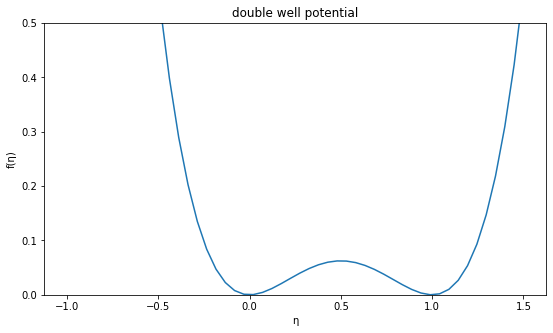

In [2]:

def f(eta):
    return (eta)**2*(eta-1)**2

plt.figure(figsize=(9,5))
_=plt.plot(np.linspace(-1,1.5),f(np.linspace(-1,1.5)))
_=plt.ylim((0,0.5))
_=plt.ylabel("f(\u03B7)")
_=plt.xlabel("\u03B7")
_=plt.title("double well potential")

In [3]:
 #Step 1.1
def F(eta):
    return 2.*eta*(eta-1)**2+2.*(eta-1)*eta*eta
    

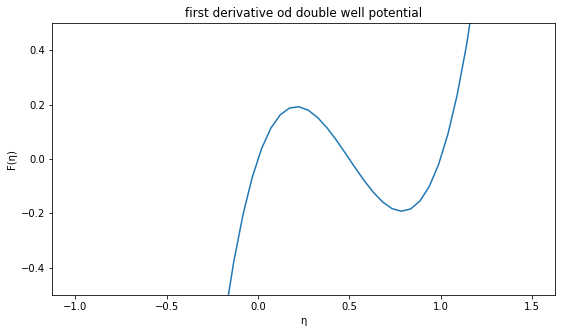

In [4]:
plt.figure(figsize=(9,5))
_=plt.plot(np.linspace(-1,1.5),F(np.linspace(-1,1.5)))
_=plt.ylim((-0.5,0.5))
_=plt.ylabel("F(\u03B7)")
_=plt.xlabel("\u03B7")
_=plt.title("first derivative od double well potential")


In [5]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    # Insert here what was in notebook 9
    basis=[]
    
    for i in range(len(support_points)):

        c= support_points*0
        c[i]=1
        bi=PPoly.from_spline(splrep(support_points,c,k=degree))
        basis.append(bi)
    # after you have computed the basis, return it
    # return basis
    return basis

In [6]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    # Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e., unique(basis.x)), and 
    # create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval. Put all of these 
    # together, and return the result
    intervals = np.unique(basis[0].x)
    # n_gauss_quadrature_points will be degree + 1
    qp, w = np.polynomial.legendre.leggauss(degree+1)
    # rescale points, weights to work in the interval [0,1] ,default [-1,1]
    qp = (qp+1)/2
    w /= 2
    # replicate these points and weights in all the intervals
    h= np.diff(intervals)
    global_quadrature = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    # return gloabl_quadrature, global_weights
    return global_quadrature, global_weights

In [7]:
# Step 1.4

def compute_system_matrices(basis, global_quadrature, global_weights):
    # Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them
    m=len(basis)
    dbasis = [bi.derivative(1) for bi in basis] 
    Bq = np.array([basis[i](global_quadrature) for i in range (m)]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(m)]).T
    M = np.einsum('qi,q,qj',Bq, global_weights,Bq)
    K = einsum('qi,q,qj',dBq, global_weights, dBq)
    
    # return M, K
    return M,K

In [8]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta, containing the solution at all points
    support_points = np.linspace(0,1,ndofs)
    basis = compute_basis_functions(support_points, degree)
    global_quadrature, global_weights = compute_global_quadrature(basis, degree+1)
    M,K = compute_system_matrices(basis, global_quadrature, global_weights)
    # time € [0,T]
    T = 1.0
    # preparing in/output
    n=int(T/dt)
    eta = np.zeros((n+1,ndofs))
    A = M + eps*eps*dt*K
    eta0 = eta_0_function(support_points)
    eta[0,:] = eta0;
    
    for i in range(1,n+1):
        b = M.dot(eta0-dt*F(eta0))
        eta1 = np.linalg.solve(A,b)
        eta[i,:] = eta1;
        eta0=eta1
    
    #return eta, basis
    return eta, basis

In [57]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution,l):
    # plot eta[::stride], on x = linspace(0,1,resolution)
    x = np.linspace(0,1,resolution) 
    B = np.zeros((resolution,len(basis)))
    T = 1.0
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    eta_t = eta[::stride].dot(B.T)
    n = eta_t.shape[0]
    m = eta.shape[0] - 1
    for i in range (n):
        plt.plot(x,eta_t[i,:],label= "time = "+str(i*stride*T/m))
    if (l ==1):
        plt.legend()
    plt.xlabel("x")
    plt.ylabel("\u03B7\u209C(x)")
    plt.title("Solution \u03B7\u209C(x)")
    
   

In [54]:
#Solve the problem for all combinations
def eta_0_function(x):
    return np.sin(2*np.pi*x)+1
degree = 1
while (degree<4):
    eps =[0.01,0.001]
    ndofs =[128,32,64,128]
    dt = [0.25,0.125,0.0625,0.03125,0.015625]
    for j in range(len(dt)):
        for k in range(len(ndofs)):
            for i in range(len(eps)):
                eta,basis = solve_allen_cahan(eta_0_function, eps[i], dt[j], ndofs[k], degree)
    degree += 1

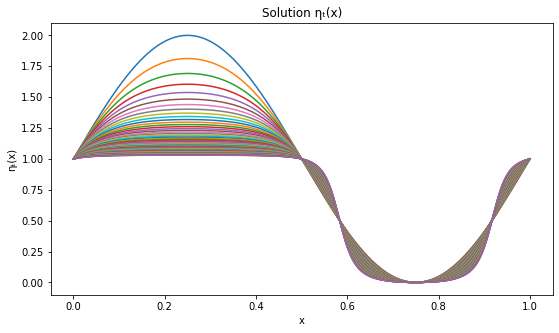

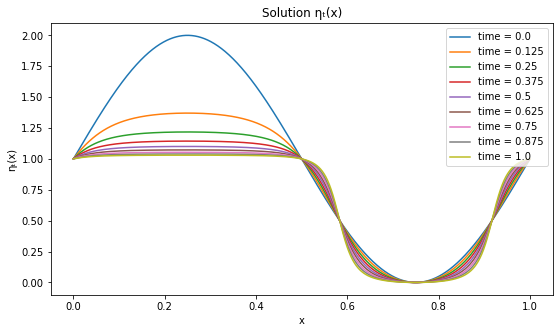

In [82]:
#Examples of solution of different stride with degree=3,dt=0.015625,ndofs=128,eps=0.001
stride = 1
resolution = 1025
l = 0
plt.figure(figsize=(9,5))
plot_solution(eta,basis,stride,resolution,l)

stride = 8
l = 1
plt.figure(figsize=(9,5))
plot_solution(eta,basis,stride,resolution,l)

In [98]:
def show_result(eta,basis,resolution,eps,dt,ndofs):
    x = np.linspace(0,1,resolution)
    B = np.zeros((resolution,len(basis)))
    title = "at dt=" + str(dt) + " ,ndofs=" + str(ndofs)+" \u03b5=" + str(eps) + " "   
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    plt.figure(figsize=(5,3))
    plt.plot(x,eta[-1,:].dot(B.T), label = "t=1")
    plt.plot(x,eta[0,:].dot(B.T), label = "t=0")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("\u03B7\u209C(x)")
    plt.title("solution \u03B7\u209C(x)" + title)

Solution at degree 1


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


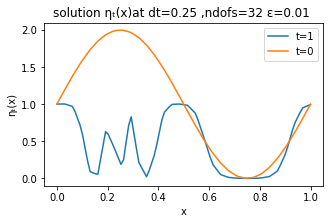

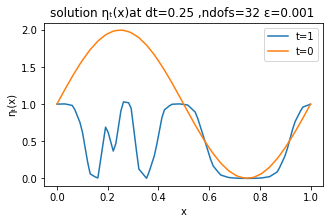

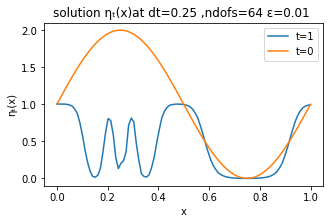

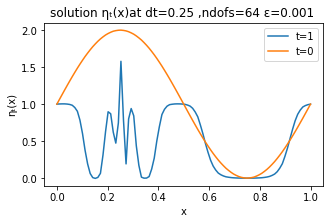

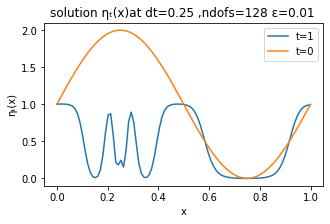

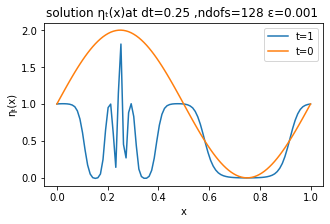

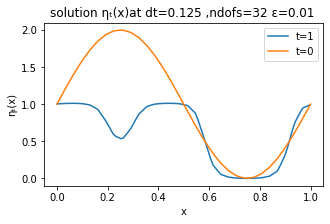

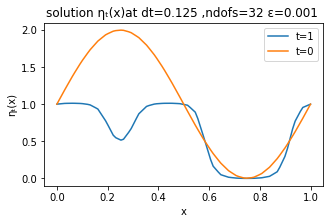

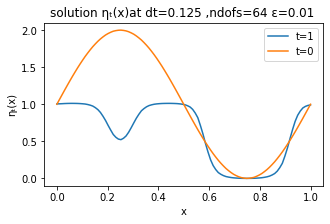

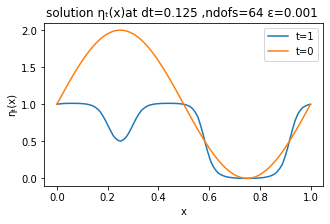

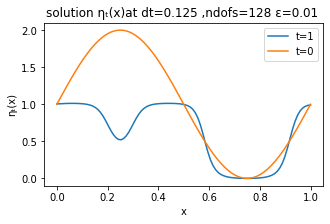

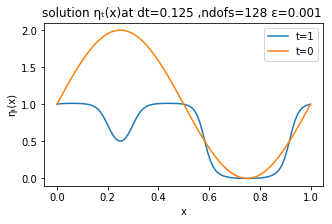

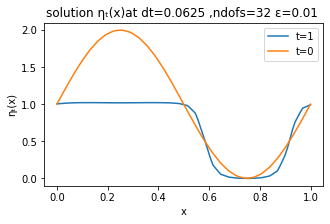

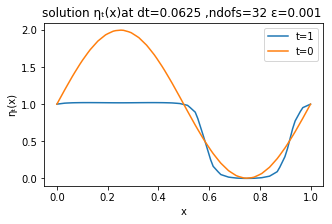

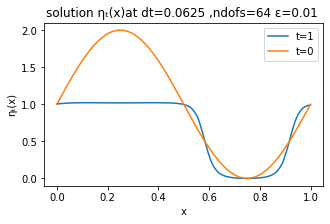

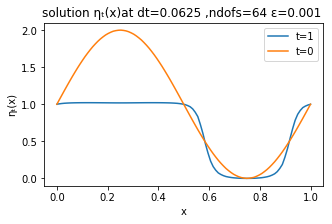

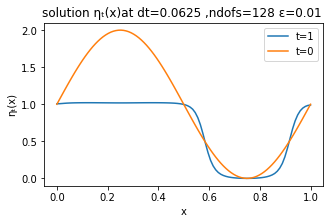

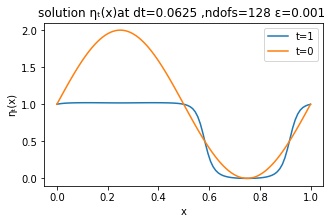

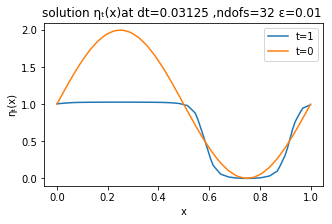

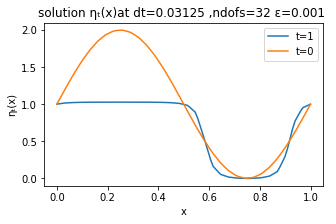

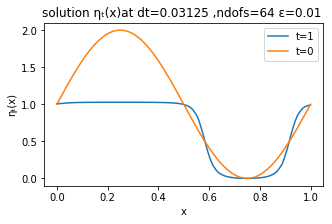

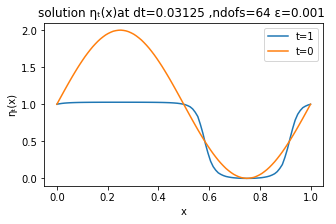

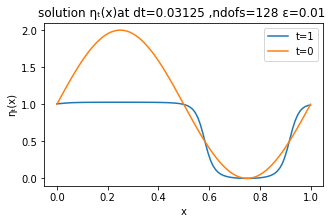

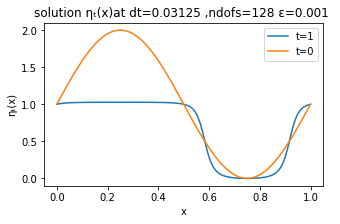

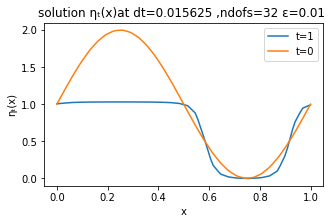

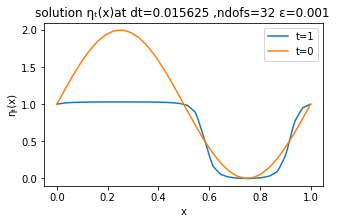

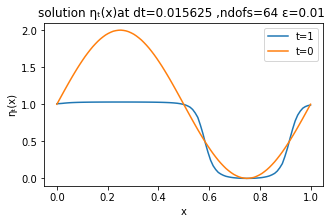

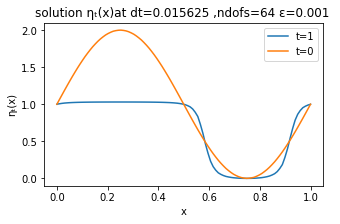

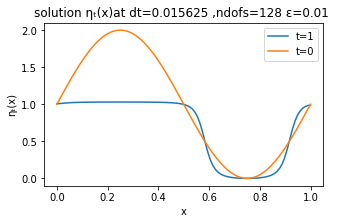

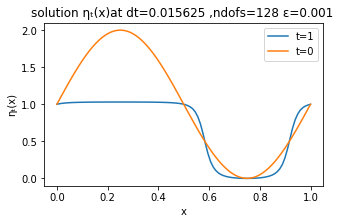

In [109]:
def eta_0_function(x):
    return np.sin(2*np.pi*x)+1
degree = 1
print ("Solution at degree "+str(degree))
eps =[0.01,0.001]
ndofs =[32,64,128]
dt = [0.25,0.125,0.0625,0.03125,0.015625]
for j in range(len(dt)):
    for k in range(len(ndofs)):
        for i in range(len(eps)):
            eta,basis = solve_allen_cahan(eta_0_function, eps[i], dt[j], ndofs[k], degree)
            show_result(eta,basis,100,eps[i],dt[j],ndofs[k])

Solution at degree 2


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


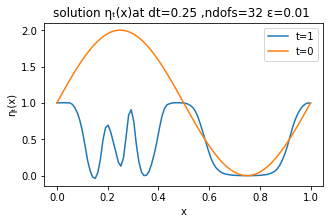

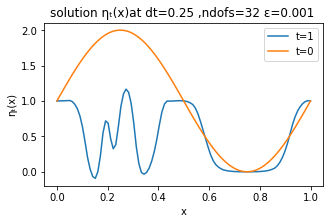

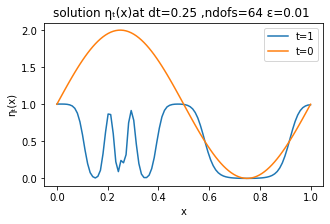

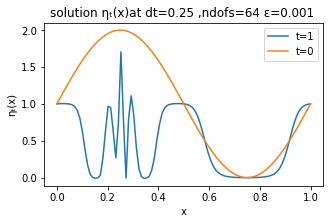

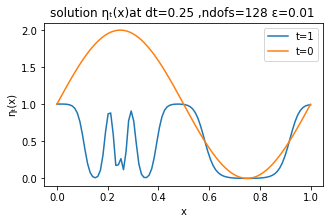

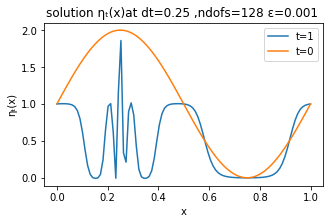

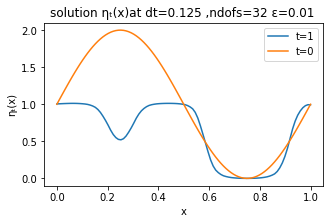

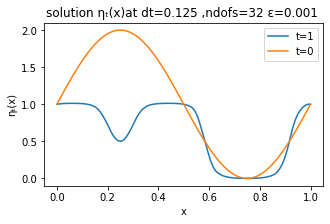

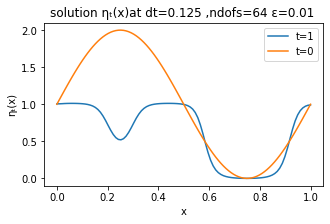

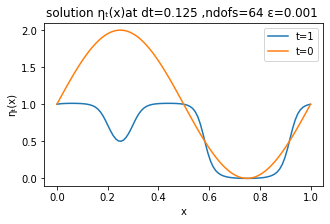

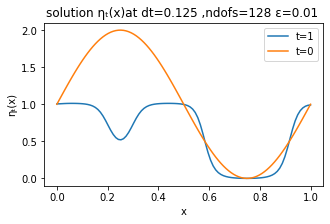

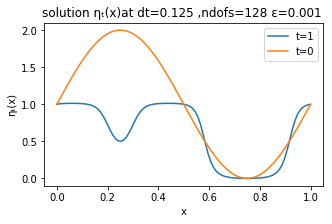

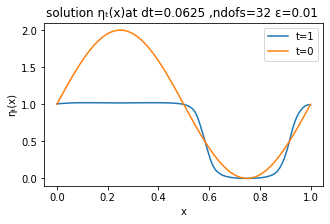

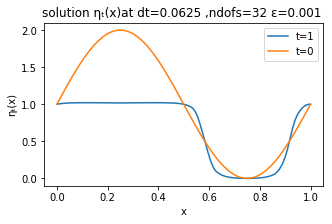

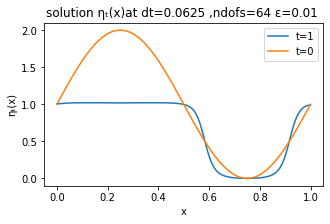

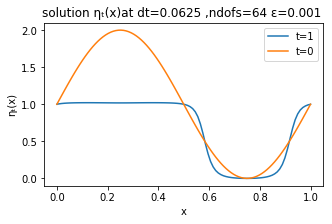

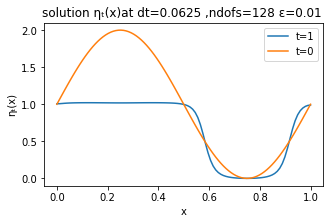

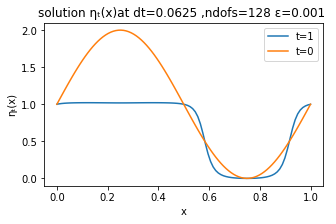

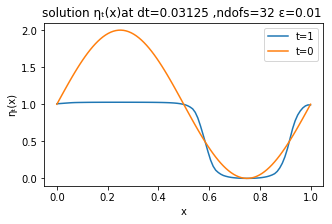

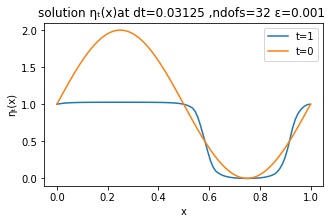

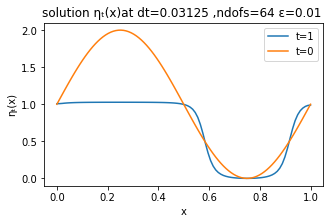

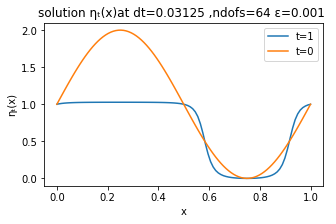

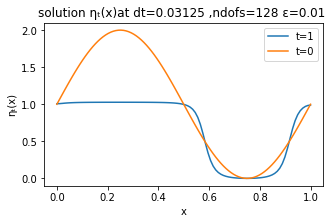

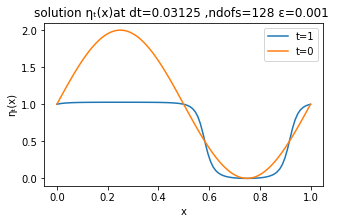

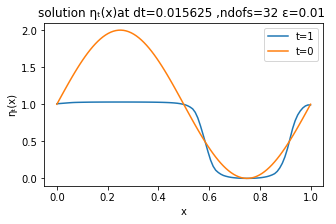

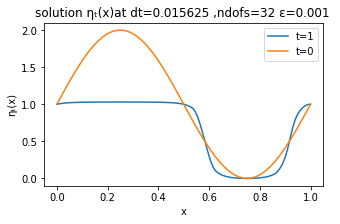

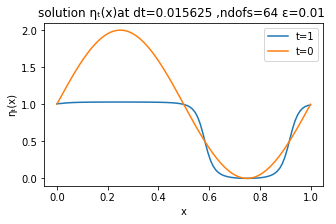

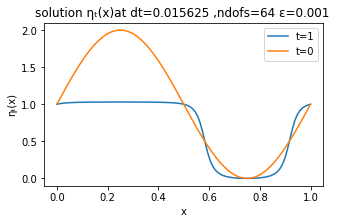

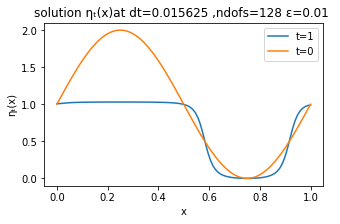

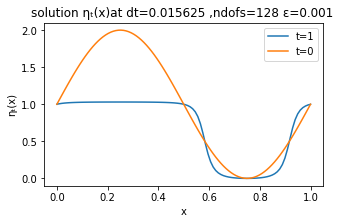

In [106]:
degree = 2
print ("Solution at degree "+str(degree))
eps =[0.01,0.001]
ndofs =[32,64,128]
dt = [0.25,0.125,0.0625,0.03125,0.015625]
for j in range(len(dt)):
    for k in range(len(ndofs)):
        for i in range(len(eps)):
            eta,basis = solve_allen_cahan(eta_0_function, eps[i], dt[j], ndofs[k], degree)
            show_result(eta,basis,100,eps[i],dt[j],ndofs[k])


Solution at degree 3


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


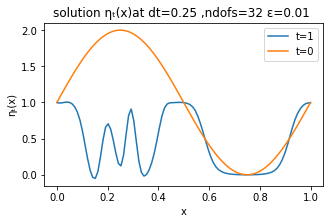

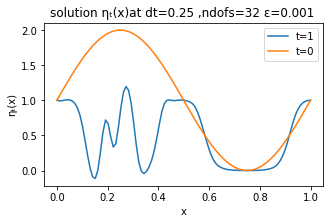

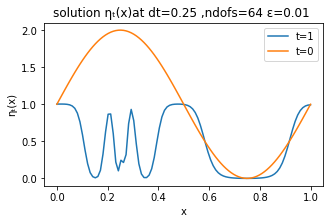

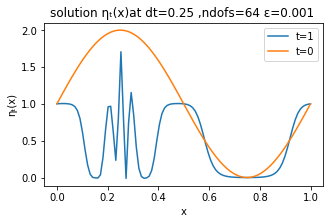

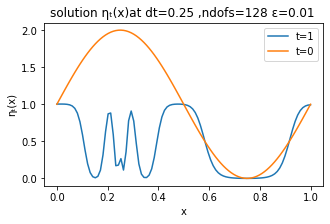

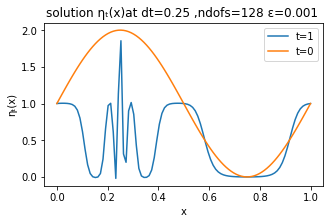

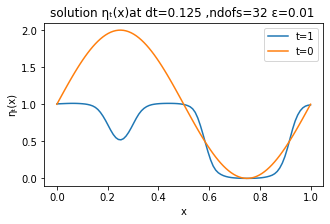

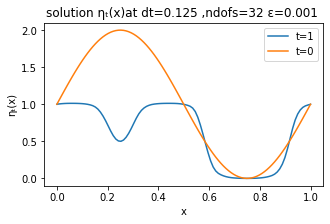

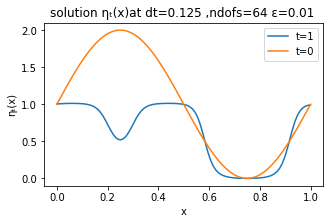

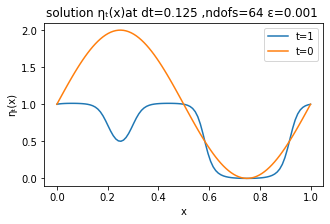

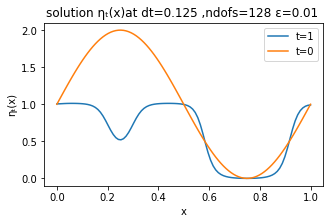

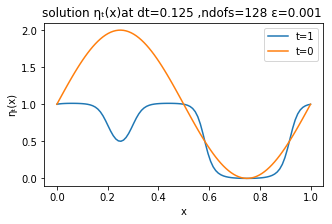

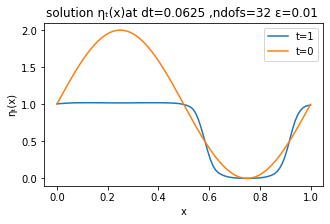

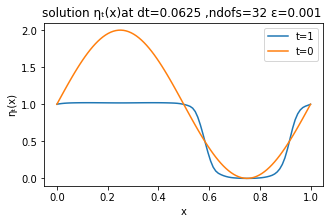

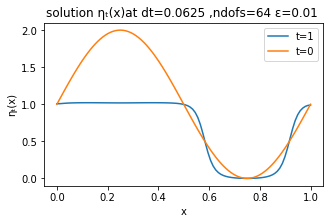

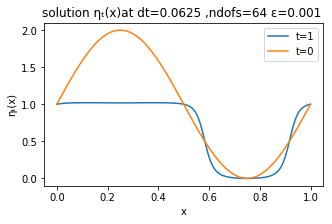

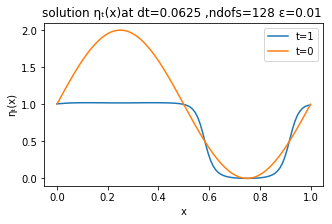

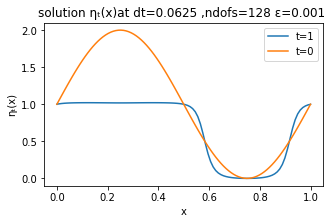

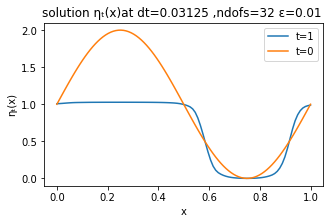

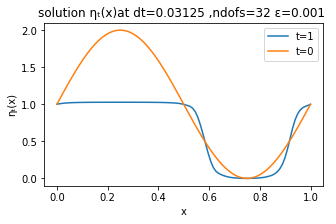

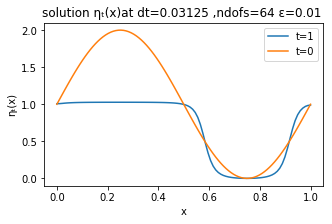

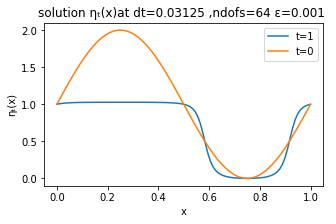

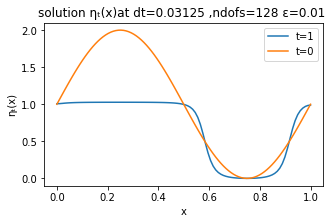

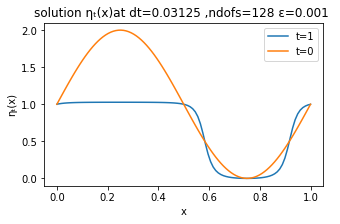

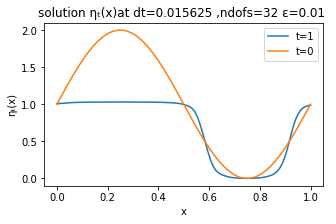

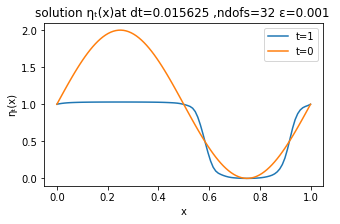

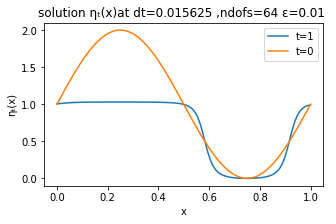

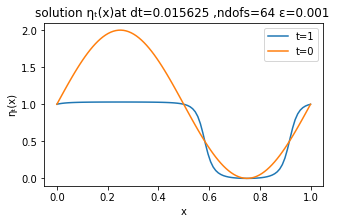

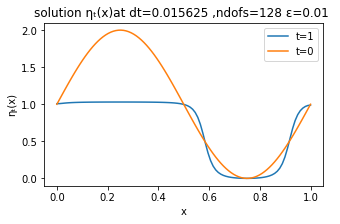

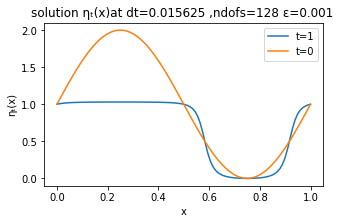

In [107]:
degree = 3
print ("Solution at degree "+str(degree))
eps =[0.01,0.001]
ndofs =[32,64,128]
dt = [0.25,0.125,0.0625,0.03125,0.015625]
for j in range(len(dt)):
    for k in range(len(ndofs)):
        for i in range(len(eps)):
            eta,basis = solve_allen_cahan(eta_0_function, eps[i], dt[j], ndofs[k], degree)
            show_result(eta,basis,100,eps[i],dt[j],ndofs[k])


From the above plots we can notice:
- Only for $\Delta t < 0.125$ the numerical solution seems to be precise given our potential. For $\Delta t > 0.125$ forward Eulero method does not ensure stability for all range of parameters. To be ensure that the method converges also for big $\Delta t$ we could use backward Eulero method.
- Keeping $\Delta t = cost$ at increasing of $ndofs$ points we can observe that the numerical solution appears smoother, as well as when we increase the degree of polynomials